# Comparison Between Wrong and Correct Cross-Validation Procedures

When building predictive models, the way we perform cross-validation (CV) is crucial for obtaining an unbiased estimate of a model's performance. Below is a detailed comparison between the two approaches using the following experiment as context:

- **Experiment Setup:**  
  We have \(N = 50\) samples split into two equal-size classes and \(p = 5000\) predictors generated as standard Gaussian noise (independent of the class labels). The true test error for any classifier in this setting is 50%.

- **Flawed (Wrong) Procedure:**  
  1. **Variable Selection on the Full Dataset:**  
     Compute the univariate Pearson correlation between each predictor and the class labels using **all** \(N\) samples. Then, select the top \(m\) predictors (e.g., 100) with the highest correlations.
     
  2. **Classifier Training and CV:**  
     Build a classifier (e.g., 1-nearest neighbor) using only the pre-selected predictors and perform \(K\)-fold CV on the entire dataset.  
     
  3. **Observed Outcome:**  
     Due to the fact that the variable selection has been influenced by the test data in every fold, the CV error can be dramatically underestimated (e.g., around 3% error instead of the true 50%). Furthermore, when computing the correlations of the selected predictors on a left-out fold, these correlations are inflated (e.g., averaging around 0.28 rather than 0).

- **Correct (Nested) Procedure:**  
  1. **Divide Samples into Folds:**  
     Randomly partition the \(N\) samples into \(K\) folds. For each fold \(k\), denote the test set as \(D_k\) and the training set as \(D_{-k}\).
     
  2. **Nested Variable Selection:**  
     For each fold \(k\), compute the Pearson correlation for each predictor using **only** the training data \(D_{-k}\):
     $$
     r_j = \frac{\sum_{i \in D_{-k}} \left(x_{ij} - \bar{x}_j\right)\left(y_i - \bar{y}\right)}
     {\sqrt{\sum_{i \in D_{-k}} \left(x_{ij} - \bar{x}_j\right)^2 \sum_{i \in D_{-k}} \left(y_i - \bar{y}\right)^2}},
     $$
     where:
     - \(x_{ij}\) is the value of predictor \(j\) for sample \(i\),
     - \(\bar{x}_j\) is the mean of predictor \(j\) over \(D_{-k}\),
     - \(y_i\) is the class label for sample \(i\), and
     - \(\bar{y}\) is the mean of the class labels in \(D_{-k}\).

     Then, select the top \(m\) predictors (e.g., 100) based on these correlations.
     
  3. **Classifier Training and Testing:**  
     Train your classifier using the selected predictors from the training data \(D_{-k}\), and then evaluate it on the left-out test fold \(D_k\).  
     
  4. **Aggregate the Error:**  
     Compute the overall CV error by averaging the error rates from all folds:
     $$
     \text{CV Error} = \frac{1}{K} \sum_{k=1}^{K} \text{Error}_k.
     $$
     
  5. **Expected Outcome:**  
     Since the variable selection is performed without any influence from the test set, the selected predictors are unbiased with respect to the left-out data. In a noise-only setting, the correlations computed on the test fold should average near 0, and the CV error should correctly reflect the true performance (around 50% error).

## Key Differences

| Aspect                            | **Wrong Way**                                     | **Correct Way**                                     |
|-----------------------------------|---------------------------------------------------|-----------------------------------------------------|
| **Predictor Selection**           | Performed on the full dataset                     | Performed on the training set \(D_{-k}\) in each fold |
| **Data Leakage**                  | Occurs (test data influences variable selection)  | Avoided (test data remains unseen during selection)  |
| **CV Error Estimate**             | Overly optimistic (e.g., ~3% error)                | Unbiased (reflects true performance, e.g., ~50% error) |
| **Test Fold Predictor Correlation** | Inflated (averaging around 0.28)                  | Unbiased (averages around 0)                         |

## Conclusion

Embedding the entire modeling process—including variable selection—inside the cross-validation loop is essential.  
- **Wrong Way:**  
  Leads to data leakage, resulting in an overly optimistic error estimate because the predictors have been chosen with full knowledge of the entire dataset.
  
- **Correct Way:**  
  By selecting predictors solely from the training data in each fold, the test set remains completely independent. This ensures that the CV error accurately estimates how the model will perform on truly unseen data.

Using the correct nested cross-validation procedure, we avoid misleading conclusions and obtain a performance estimate that is valid for real-world applications.


Average CV Error over 50 experiments: 3.56%


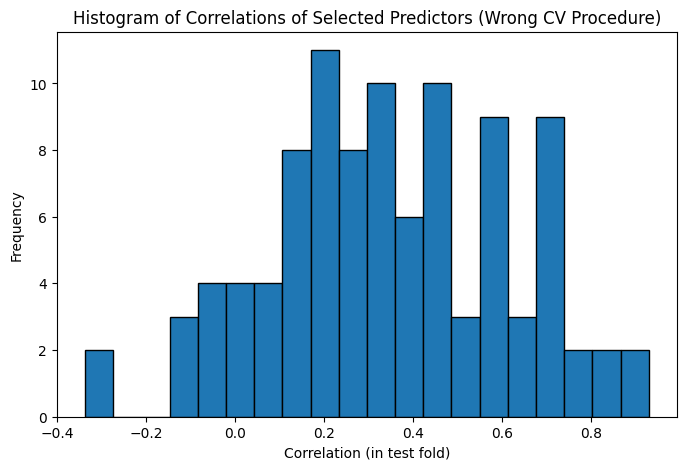

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def simulate_experiment(n_samples=50, n_features=5000, n_selected=100, n_splits=5):
    """
    Simulate one iteration of the flawed cross-validation experiment.
    
    Parameters:
        n_samples (int): Total number of samples (default 50).
        n_features (int): Total number of predictors (default 5000).
        n_selected (int): Number of predictors to select based on correlation (default 100).
        n_splits (int): Number of cross-validation folds (default 5).
    
    Returns:
        avg_cv_error (float): The average cross-validation error for this simulation.
        test_fold_corr (np.array): Correlations of the selected predictors with the outcome computed on
                                   one test fold (for histogram plotting).
    """
    # Generate class labels for two equal-sized classes (0 and 1)
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))
    # Randomize sample order (not necessary for the simulation, but more realistic)
    np.random.shuffle(y)
    
    # Generate the predictor matrix X (each predictor is standard Gaussian noise)
    X = np.random.randn(n_samples, n_features)
    
    # --- Step 1: Compute correlations using all samples ---
    # For each predictor, compute the Pearson correlation with the class labels.
    mean_y = np.mean(y)
    std_y = np.std(y, ddof=1)
    X_means = np.mean(X, axis=0)
    X_stds = np.std(X, axis=0, ddof=1)
    
    # Compute covariance for each predictor with y
    cov = np.sum((X - X_means) * (y.reshape(-1, 1) - mean_y), axis=0) / (n_samples - 1)
    correlations = cov / (X_stds * std_y)
    
    # Select the indices of the 100 predictors with the highest correlations (not using absolute values)
    top_indices = np.argsort(correlations)[-n_selected:]
    
    # --- Step 2 & 3: Build 1-NN classifier and estimate error via cross-validation ---
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_errors = []
    test_fold_corr = None  # This will store correlations on one test fold for histogram
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        # Use the pre-selected predictors for both training and testing
        X_train = X[train_idx][:, top_indices]
        y_train = y[train_idx]
        X_test = X[test_idx][:, top_indices]
        y_test = y[test_idx]
        
        # Train a 1-nearest neighbor classifier on the training fold
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, y_train)
        
        # Predict class labels for the test fold and compute error rate
        y_pred = knn.predict(X_test)
        fold_error = np.mean(y_pred != y_test)
        cv_errors.append(fold_error)
        
        # For the first fold, compute the correlations of the selected predictors on the test fold.
        # This mimics the "wrong" procedure where the predictors have already "seen" the test data.
        if fold_idx == 0:
            n_test = len(test_idx)
            mean_y_test = np.mean(y_test)
            std_y_test = np.std(y_test, ddof=1)
            fold_corr = []
            for j in range(n_selected):
                x_j = X_test[:, j]
                mean_xj = np.mean(x_j)
                std_xj = np.std(x_j, ddof=1)
                cov_j = np.sum((x_j - mean_xj) * (y_test - mean_y_test)) / (n_test - 1)
                corr_j = cov_j / (std_xj * std_y_test)
                fold_corr.append(corr_j)
            test_fold_corr = np.array(fold_corr)
    
    avg_cv_error = np.mean(cv_errors)
    return avg_cv_error, test_fold_corr

# Repeat the experiment 50 times
n_experiments = 50
cv_error_list = []
correlations_hist = None  # We will use the correlations from the first experiment's first fold for the histogram

for i in range(n_experiments):
    error, test_corr = simulate_experiment()
    cv_error_list.append(error)
    # Save the test fold correlations from the first experiment for plotting
    if i == 0:
        correlations_hist = test_corr

avg_cv_error_overall = np.mean(cv_error_list)
print("Average CV Error over {} experiments: {:.2%}".format(n_experiments, avg_cv_error_overall))

# Plot histogram of correlations of selected predictors (from one test fold)
plt.figure(figsize=(8, 5))
plt.hist(correlations_hist, bins=20, edgecolor='black')
plt.xlabel("Correlation (in test fold)")
plt.ylabel("Frequency")
plt.title("Histogram of Correlations of Selected Predictors (Wrong CV Procedure)")
plt.show()


Average CV Error (Correct Procedure) over 50 experiments: 53.44%


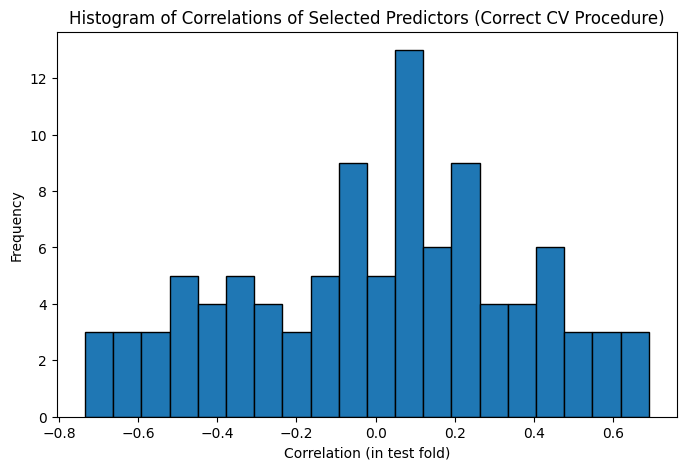

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def simulate_experiment_correct(n_samples=50, n_features=5000, n_selected=100, n_splits=5):
    """
    Simulate one iteration of the correctly nested cross-validation experiment.
    
    Parameters:
        n_samples (int): Total number of samples (default 50).
        n_features (int): Total number of predictors (default 5000).
        n_selected (int): Number of predictors to select based on correlation (default 100).
        n_splits (int): Number of cross-validation folds (default 5).
    
    Returns:
        avg_cv_error (float): The average cross-validation error for this simulation.
        test_fold_corr (np.array): Correlations of the selected predictors with the outcome,
                                   computed on one test fold (for histogram plotting).
    """
    # Generate class labels for two equal-sized classes (0 and 1)
    y = np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))
    np.random.shuffle(y)
    
    # Generate the predictor matrix X (each predictor is standard Gaussian noise)
    X = np.random.randn(n_samples, n_features)
    
    # Prepare cross-validation splits
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_errors = []
    test_fold_corr = None  # To store correlations from one test fold for the histogram
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        # Split the data into training and test sets for this fold
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        
        # --- Step 1: Variable Selection on Training Data ---
        # Compute the univariate Pearson correlations for each predictor using only training data
        mean_y_train = np.mean(y_train)
        std_y_train = np.std(y_train, ddof=1)
        X_train_means = np.mean(X_train, axis=0)
        X_train_stds = np.std(X_train, axis=0, ddof=1)
        
        # Compute covariance between each predictor and the class labels on the training data
        cov = np.sum((X_train - X_train_means) * (y_train.reshape(-1, 1) - mean_y_train), axis=0) / (len(train_idx) - 1)
        correlations_train = cov / (X_train_stds * std_y_train)
        
        # Select the indices of the top predictors (here, the 100 with highest correlation)
        top_indices = np.argsort(correlations_train)[-n_selected:]
        
        # --- Step 2: Build the Classifier on Training Data ---
        # Subset the training and test data to the selected predictors
        X_train_selected = X_train[:, top_indices]
        X_test_selected = X_test[:, top_indices]
        
        # Train a 1-nearest neighbor classifier using the selected predictors on the training data
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train_selected, y_train)
        
        # --- Step 3: Evaluate on the Test Fold ---
        y_pred = knn.predict(X_test_selected)
        fold_error = np.mean(y_pred != y_test)
        cv_errors.append(fold_error)
        
        # For one test fold (e.g., the first), compute the correlations of the selected predictors
        # with the class labels in the test set (this should average around zero)
        if fold_idx == 0:
            n_test = len(test_idx)
            mean_y_test = np.mean(y_test)
            std_y_test = np.std(y_test, ddof=1)
            fold_corr = []
            for j in range(n_selected):
                x_j = X_test_selected[:, j]
                mean_x_j = np.mean(x_j)
                std_x_j = np.std(x_j, ddof=1)
                cov_j = np.sum((x_j - mean_x_j) * (y_test - mean_y_test)) / (n_test - 1)
                corr_j = cov_j / (std_x_j * std_y_test)
                fold_corr.append(corr_j)
            test_fold_corr = np.array(fold_corr)
    
    avg_cv_error = np.mean(cv_errors)
    return avg_cv_error, test_fold_corr

# Run the simulation 50 times
n_experiments = 50
cv_error_list = []
corr_hist = None  # Store correlations from the first experiment's first test fold

for i in range(n_experiments):
    error, test_corr = simulate_experiment_correct()
    cv_error_list.append(error)
    if i == 0:
        corr_hist = test_corr

avg_cv_error_overall = np.mean(cv_error_list)
print("Average CV Error (Correct Procedure) over {} experiments: {:.2%}".format(n_experiments, avg_cv_error_overall))

# Plot histogram of correlations (from one test fold)
plt.figure(figsize=(8, 5))
plt.hist(corr_hist, bins=20, edgecolor='black')
plt.xlabel("Correlation (in test fold)")
plt.ylabel("Frequency")
plt.title("Histogram of Correlations of Selected Predictors (Correct CV Procedure)")
plt.show()
